In [1]:
import torch
from torchvision import datasets
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

import models, utils

DATASET = datasets.FashionMNIST

In [31]:
# Prepare datasets/loaders
train_data, test_data = utils.loadDataset(DATASET)
train_loader   = utils.createDataLoader(train_data)
test_loader    = utils.createDataLoader(test_data)

In [2]:
logger = pl.loggers.CSVLogger("")

path="reduce.ckpt"
model = models.DimensionReductionModel.load_from_checkpoint(path, model=models.BasicConvAutoencoder)
dimensions=model.dimensions
print(f"Loaded model {path} with {dimensions}D")

trainer = pl.Trainer(logger=logger, **utils.TRAINER_ARGS)
train_encodings = torch.cat(trainer.predict(model, train_loader))
test_encodings = torch.cat(trainer.predict(model, test_loader))

train_npdata = utils.numpyConvert(train_data.data)
test_npdata = utils.numpyConvert(test_data.data)
train_encodings = utils.numpyConvert(train_encodings)
test_encodings = utils.numpyConvert(test_encodings)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True


Loaded model reduce.ckpt with 24D


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


NameError: name 'train_loader' is not defined

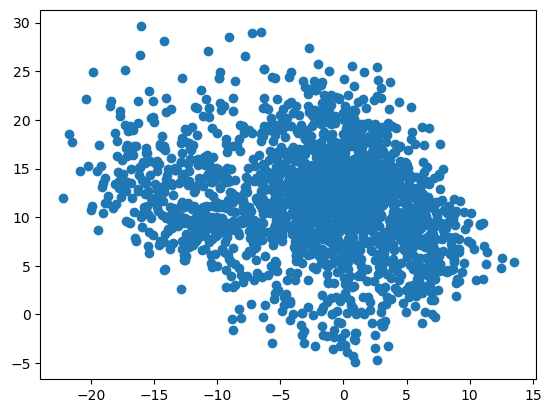

In [51]:
# Visualise a random 2D slice
num_points = 2000
idxs = np.random.randint(0, len(train_encodings), num_points)

ax0 = np.random.normal(0, 1, dimensions)
ax0 /= np.linalg.norm(ax0)

ax1 = np.random.normal(0, 1, dimensions)
ax1 = ax1 - ax0 * np.dot(ax0, ax1) # Perpendicular
ax1 /= np.linalg.norm(ax1)


points = train_encodings[idxs]
plt.scatter(np.dot(points, ax0), np.dot(points, ax1))
plt.show()

In [53]:
# Evaluate accuracy of NNs in reduced dimensional space
num_queries = 500
num_points = 10000
idxs = np.random.randint(0, len(test_npdata), num_queries)

errors = []
for idx in idxs:
    query = test_npdata[idx]
    query_enc = test_encodings[idx]

    deltas = train_npdata[:num_points] - query
    deltas_enc = train_encodings[:num_points] - query_enc

    deltas = np.sum(np.square(deltas), 1)
    deltas_enc = np.sum(np.square(deltas_enc), 1)

    nn = np.argmin(deltas)
    sort_enc = np.argsort(deltas_enc)

    error = np.argmax(sort_enc == nn)
    errors.append(error)

errors = np.array(errors)
print("Raw: ", errors[:20])
print("Ave.:", np.mean(errors))
print("Dev.:", np.std(errors))
print("Acc.:", 100 * np.mean(errors == 0), "%")
print("Max.:", np.max(errors))

Raw:  [  0 232   0   1   4   0   7   6   1   4   6   0   9   0   0   1   0   1
   0 116]
Ave.: 4.76
Dev.: 15.634014199814455
Acc.: 38.4 %
Max.: 232


In [13]:
uniform_data = utils.UniformDataset(2, 50_000)
args = utils.LOADER_ARGS
args["batch_size"] = 16
uniform_loader = torch.utils.data.DataLoader(uniform_data, **args)

In [16]:
# Train a space-filling curve
sfc = models.SFCModel(models.BasicNN, inputs=2, width=5000, p=2.0)
args = utils.TRAINER_ARGS
args["max_epochs"] = 2
trainer = pl.Trainer(logger=logger, **args)
trainer.fit(sfc, uniform_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | BasicNN | 25.0 M
----------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
50.050    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3125it [00:00, ?it/s]

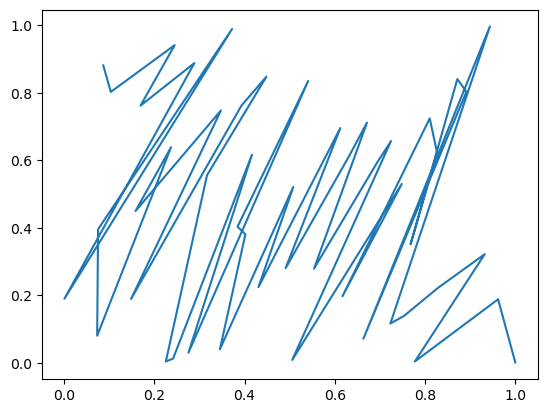

In [18]:
zero_data = utils.UniformDataset(1, 1)
d = np.copy(uniform_data.data.detach().cpu().numpy())
#d[:,2] = 0.0
zero_data.data = torch.from_numpy(d)
zero_loader = utils.createDataLoader(zero_data)

uniform_encodings = torch.cat(trainer.predict(sfc, zero_loader))
uniform_encodings = utils.numpyConvert(uniform_encodings).flatten()
uniform_npdata = utils.numpyConvert(zero_data.data)

order = np.argsort(uniform_encodings)
uniform_sorted = uniform_npdata[order]

samples = 100
xs = []
ys = []
for i in range(samples):
    idx = int(i/samples * len(uniform_data))
    xs.append(uniform_sorted[idx][0])
    ys.append(uniform_sorted[idx][1])

plt.plot(xs, ys)
plt.show()